**TP Filtres de Kalman d'ensemble : erreur d'échantillonnage et localisation**

L'objectif de ce TP est l'illustration de  l'impact des erreurs d'échantillonnage sur l'estimation de la matrice de covariance d'erreur de prévision ${\bf P}_f$, ainsi qu'une stratégie appelée localisation, permettant d'y remédier partiellement. 

*Sources*: ce TP s'inspire d'un notebook d'E. Cosme (UGA).


In [8]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline

**Estimation de matrice de covariance et erreur d'echantillonnage**

On considère un domaine péridique 1D, muni d'une grille régulière, ainsi que la solution d'une EDP ne faisant intervenir qu'une seule variable. On suppose avoir développé un système d'assimilation de données par filtrage de Kalman d'ensemble.

On suppose que la grille est faite de $40$ points de grille, ce qui fait que le vecteur d'état est de taille $40$, et la matrice d'erreur de prévision associée de taille $40 \times 40$. L'objectif est d'illustrer l'impact de la taille de l'ensemble, sur la qualité de l'estimation de cette matrice, en se donnant une matrice de référence, et la comparant à celles obtenues depuis echantillonnage. 

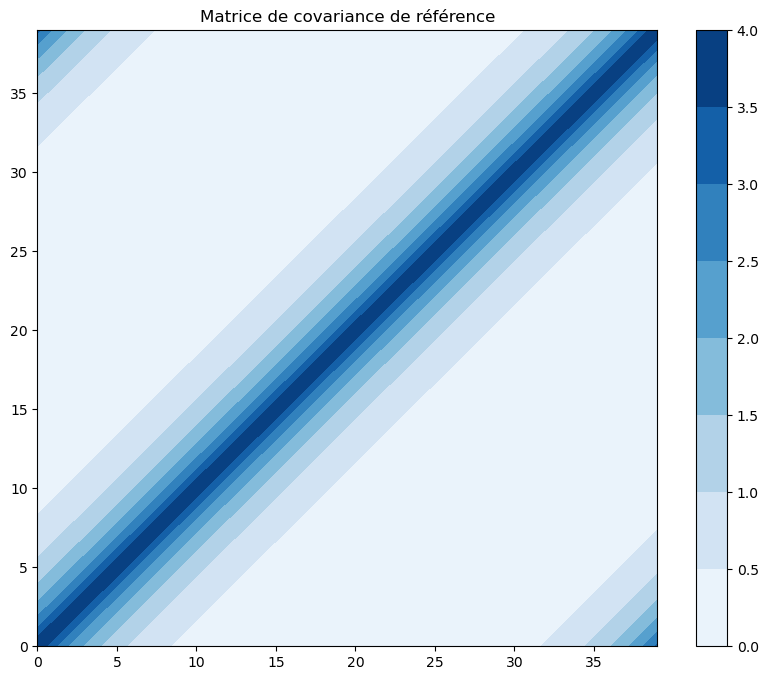

In [2]:
# Paramètres du domaine et de la grille
n_grid = 40                         
d_grid = 1.                          
L_grid = n_grid * d_grid             
x_grid = d_grid * np.arange(n_grid)  
X,Y = np.meshgrid(x_grid, x_grid)

# Matrice de référence P_t
dcut = 4.                            # longeur de corrélation
variance = 4.                        # variace
Pt = np.zeros((n_grid, n_grid))
for j in range(n_grid):
    for i in range(n_grid):
        rad = np.abs(x_grid[i]-x_grid[j])
        rad = np.min((rad,L_grid-rad))        # conditions aux frontières périodiques
        Pt[i,j] = variance * np.exp(-rad/dcut)
        
fig = plt.figure(figsize=(10,8))
im = plt.contourf(X, Y, Pt, cmap = cm.Blues)
plt.title('Matrice de covariance de référence')
fig.colorbar(im)

Soit ${\bf E}=[{\bf x}_1,..,{\bf x}_{Nens}]$ un ensemble de vecteur de distribution $\mathcal{N}({\bf 0},{\bf P}_t)$. On note $\displaystyle{\bar{\bf x}=\frac{1}{Nens}\sum_{i=1}^{Nens}{\bf x}_i}$ et ${\bf A}=[{\bf x}_1-\bar{\bf x},..,{\bf x}_{Nens}-\bar{\bf x}]$.

On considère l'estimateur de ${\bf P}_t$ :

$${\bf P}_e=\frac{1}{Nens-1}{\bf A}{\bf A}^T.$$

Visualiser ${\bf P}_e$ en fonction de $Nens$ et analyser l'évolution de l'erreur en norme de Frobenius.

Text(0.5, 1.0, 'Erreur relative en fonction de N_ensemble')

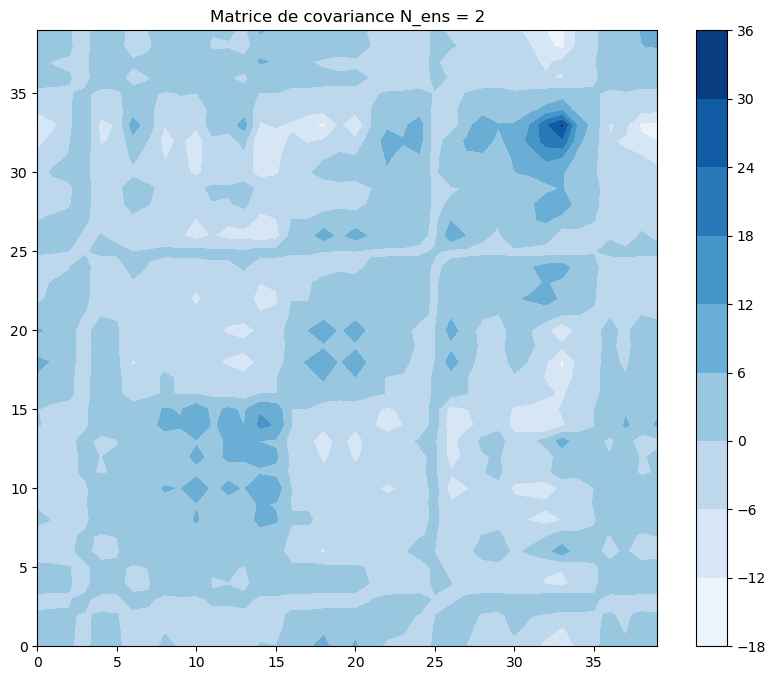

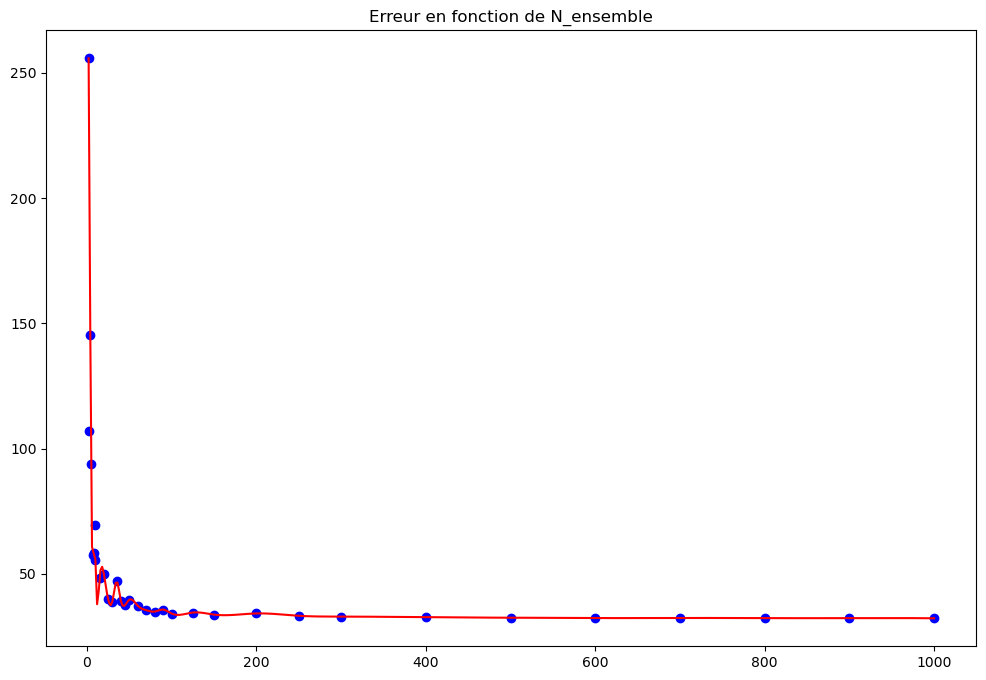

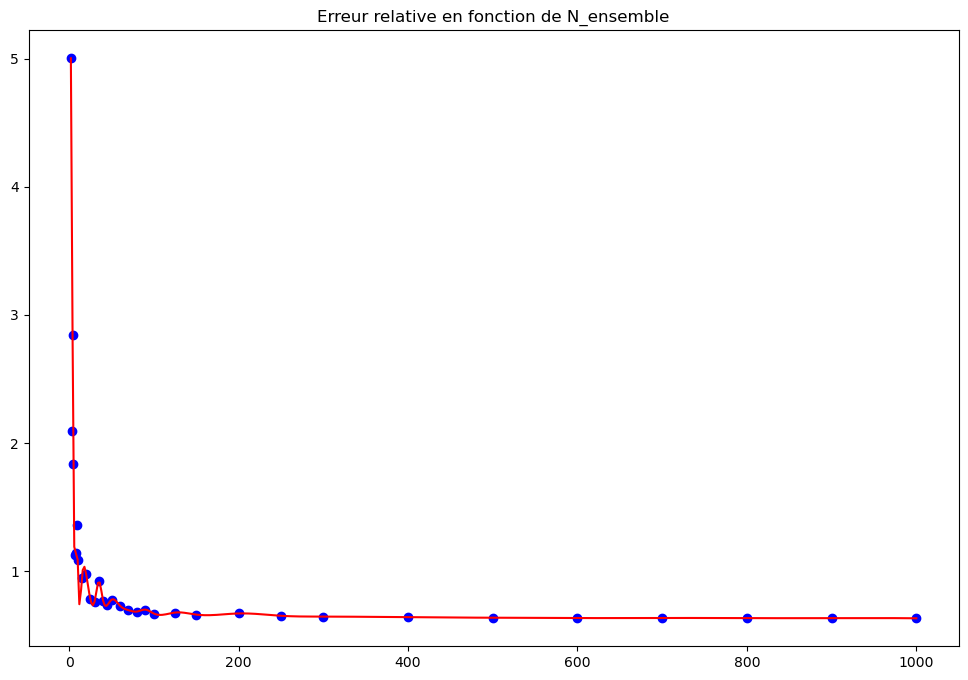

In [40]:
#Génération d'un esemble de taille Nens et calcul de Pe
from scipy.interpolate import make_interp_spline

def compute_Pe(Nens):
    mean = np.zeros(Pt.shape[0])
    E = np.random.multivariate_normal(mean, Pt, size = Nens).T
    x_mean = np.mean(E, axis = 0)
    A = E - x_mean
    Pe = (A@A.T)/(Nens-1)
    return Pe
    
# Visualisation de Pe
Nens=2
Pe=compute_Pe(Nens)
fig = plt.figure(figsize=(10,8))
im = plt.contourf(X, Y, Pe, cmap = cm.Blues)
plt.title('Matrice de covariance N_ens = 2')
fig.colorbar(im)

# Evolution de l'erreur en fonction de Nens
aNens=[2, 3, 4, 5, 7, 8 ,9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 60, 70, 80, 90, 100, 125, 150, 200, 250, 300, 400, 500, 600, 700, 800, 900, 1000]
nerr=np.zeros(len(aNens))
nerr_relative =np.zeros(len(aNens))


for i, Nens_item in enumerate(aNens):
    Pe_item = compute_Pe(Nens_item)
    nerr[i] = np.linalg.norm(Pt - Pe_item, ord='fro')
    nerr_relative[i] = np.linalg.norm(Pt - Pe_item, ord='fro')/np.linalg.norm(Pt, ord='fro')

x_smooth = np.linspace(min(aNens), max(aNens), 500)
nerr_smooth = make_interp_spline(aNens, nerr)(x_smooth)
# fig = plt.figure(figsize=(10,8))
# im = plt.plot(aNens,nerr)
plt.figure(figsize=(12, 8))
plt.plot(aNens, nerr, 'o', label='Erreur brute', color='blue')
plt.plot(x_smooth, nerr_smooth, '-', label='Interpolation lissée', color='red')

plt.title('Erreur en fonction de N_ensemble')

xr_smooth = np.linspace(min(aNens), max(aNens), 500)
nerrr_smooth = make_interp_spline(aNens, nerr_relative)(xr_smooth)
# fig = plt.figure(figsize=(10,8))
# im = plt.plot(aNens,nerr)
plt.figure(figsize=(12, 8))
plt.plot(aNens, nerr_relative, 'o', label='Erreur relative', color='blue')
plt.plot(xr_smooth, nerrr_smooth, '-', label='Interpolation lissée', color='red')

plt.title('Erreur relative en fonction de N_ensemble')

**Localisation par produit de Schur avec une matrice de localisation**

L'objectif est d'éliminer les corrélations anormalement élevées entre des points de grille "éloignés". Pour cela, une stratégie consiste à effectuer une produit de Schur (ou Hadamard) avec une matrice de localisation $\rho$ construite depuis des fonctions à support compact. Deux exemples sont l'indicatrice d'un intervalle et la fonctionde Gaspari et Cohn (1999):
$$f_1(x)=1_{[0,2]}(x), \quad \mbox{ et } \quad f_2(x)=\left\{\begin{array}{c}
1-\frac{5}{3}|x|^2+\frac{5}{8}|x|^3+\frac{1}{2}|x|^4-\frac{1}{4}|x|^5, \mbox{ si } 0\leq |x| \leq 1\\
-\frac{2}{3}|x|^{-1}+4-5|x|+\frac{5}{3}|x|^2+\frac{5}{8}|x|^3-\frac{1}{2}|x|^4+\frac{1}{12}|x|^5, \mbox{ si } 1\leq |x| \leq 2\\
0, \mbox{ si } |x| \geq 2
\end{array} \right.$$

On obtient alors $$[\rho]_{i,j}=f(\frac{\vert x(i)-x(j)\vert)}{L_e}),$$ avec $x(i)$ la coordonées du i-ème point e grille et $L_e$ une longueur de référence.


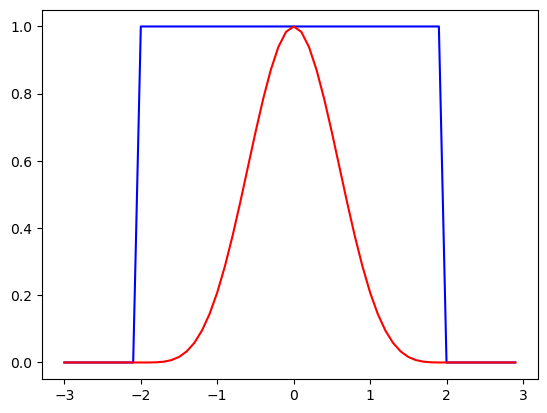

In [42]:
# Définition des fonctions de localisation
def f1(r):
    #fonction indicatrice de [0,2]
    r_abs = np.abs(r)
    if (r_abs >= 0) and (r_abs<=2):
        x=1
    else:
        x=0
    return x

def f2(r):
    r_abs = np.abs(r)
    # fonction de Gaspari-Cohn
    if (r_abs <= 1) and (r_abs >= 0):
        x = 1 - 5*(r_abs**2)/3 + 5*(r_abs**3)/8 + (r_abs**4)/2 - (r_abs**5)/4
    elif (r_abs <= 2) and (r_abs > 1):
        x = - 2*(r_abs**(-1))/3 + 4 - 5*r_abs + 5*(r_abs**2)/3 + 5*(r_abs**3)/8 - (r_abs**4)/2 + (r_abs**5)/12
    else:
        x = 0
    return x
    

x = np.arange(-3., 3., 0.1)  # z/c
plt.plot(x,list(map(f1, x)),'b',x, list(map(f2, x)),'r')

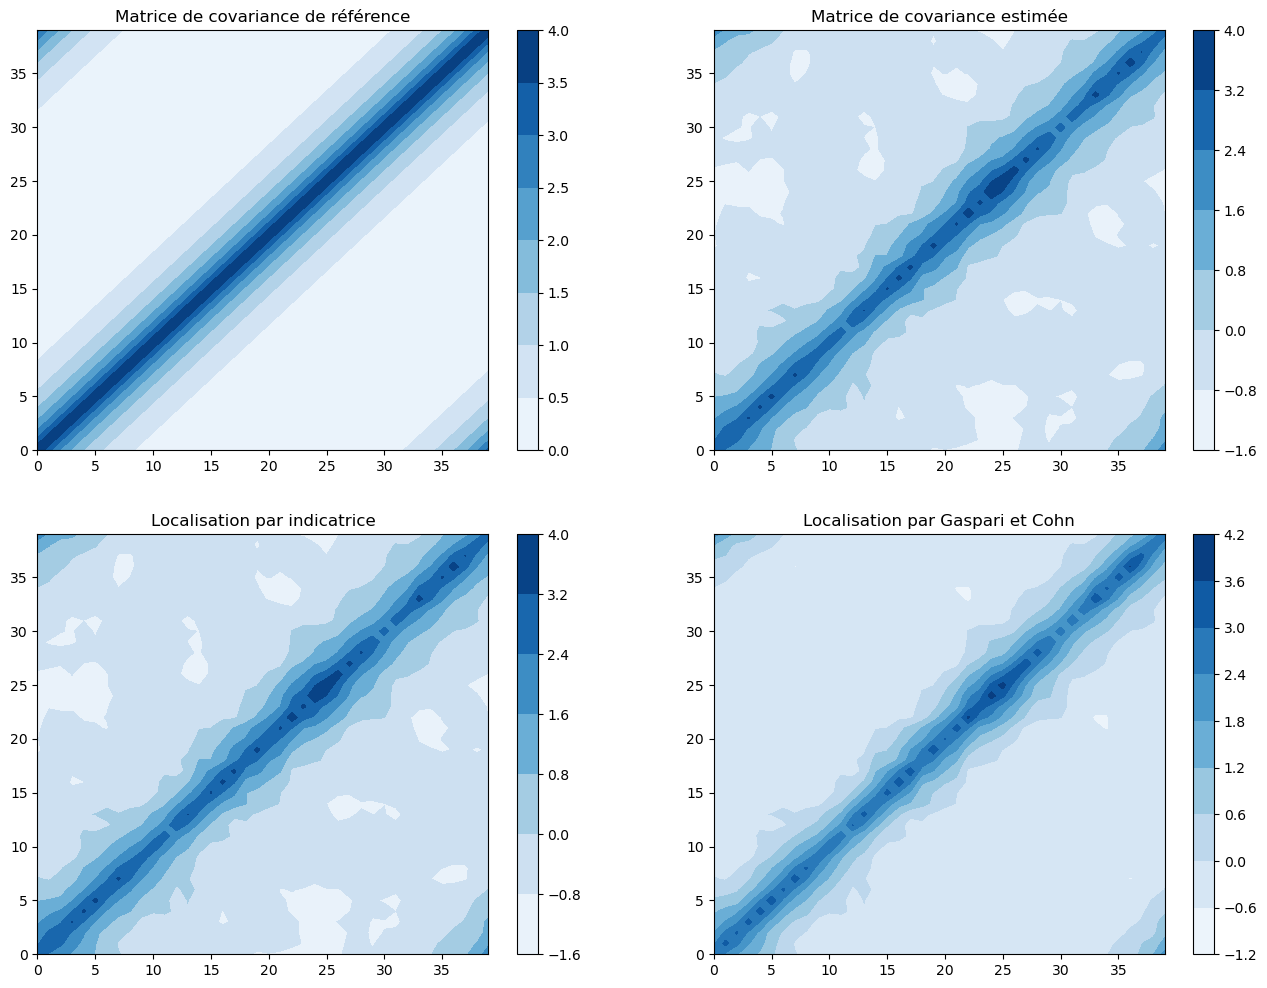

In [50]:
# Construction des matrices rho associées à f1 et f2
crad = 20.    # facteur #à faire varier #longueur à partir de laquelle on considère qu'il n'y a pas de corrélation entre 2 points

rho1 = np.zeros((n_grid, n_grid)) # f1
rho2 = np.zeros((n_grid, n_grid)) # f2

for i in range(n_grid):
    for j in range(n_grid):
        rad = np.abs(x_grid[i]-x_grid[j])
        rad = np.min((rad,L_grid-rad))        # conditions aux frontières périodiques
        rho1[i,j] = f1(rad/crad)
        rho2[i,j] = f2(rad/crad)

# Localisation de Pe
Nens=200
Pe=compute_Pe(Nens) 

Pe_loc1=np.zeros((n_grid, n_grid))
Pe_loc2=np.zeros((n_grid, n_grid))

Pe_loc1 = Pe * rho1
Pe_loc2 = Pe * rho2

# Affichage

fig = plt.figure(figsize=(16,12))
ax = plt.subplot(2,2,1)
im = ax.contourf(X, Y, Pt, cmap = cm.Blues)
ax.set_title('Matrice de covariance de référence')
fig.colorbar(im)

ax = plt.subplot(2,2,2)
im = ax.contourf(X, Y, Pe, cmap = cm.Blues)
ax.set_title('Matrice de covariance estimée')
fig.colorbar(im)

ax = plt.subplot(2,2,3)
im = ax.contourf(X, Y, Pe_loc1, cmap = cm.Blues)
ax.set_title('Localisation par indicatrice')
fig.colorbar(im)

ax = plt.subplot(2,2,4)
im = ax.contourf(X, Y, Pe_loc2, cmap = cm.Blues)
ax.set_title('Localisation par Gaspari et Cohn')
fig.colorbar(im);